# Task 2: Bayesian Change Point Detection – Brent Oil Prices
**10 Academy Week 11 Challenge**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import seaborn as sns

from datetime import datetime

az.style.use("arviz-darkgrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


## 1. Load & Prepare Data

In [3]:
data_path = "../data/brent_cleaned.csv"   # from Task 1

df = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')
df = df.sort_index()

print("Date range:", df.index.min(), "to", df.index.max())
print(df.head(3))

# Use log returns (more stationary than raw prices)
y = df['Log_Return'].dropna().values
n = len(y)

print(f"\nModeling {n} daily log returns")

Date range: 1987-05-20 00:00:00 to 2022-11-14 00:00:00
            Price  Log_Price  Log_Return  Vol_30d
Date                                             
1987-05-20  18.63   2.924773         NaN      NaN
1987-05-21  18.45   2.915064   -0.009709      NaN
1987-05-22  18.55   2.920470    0.005405      NaN

Modeling 9010 daily log returns


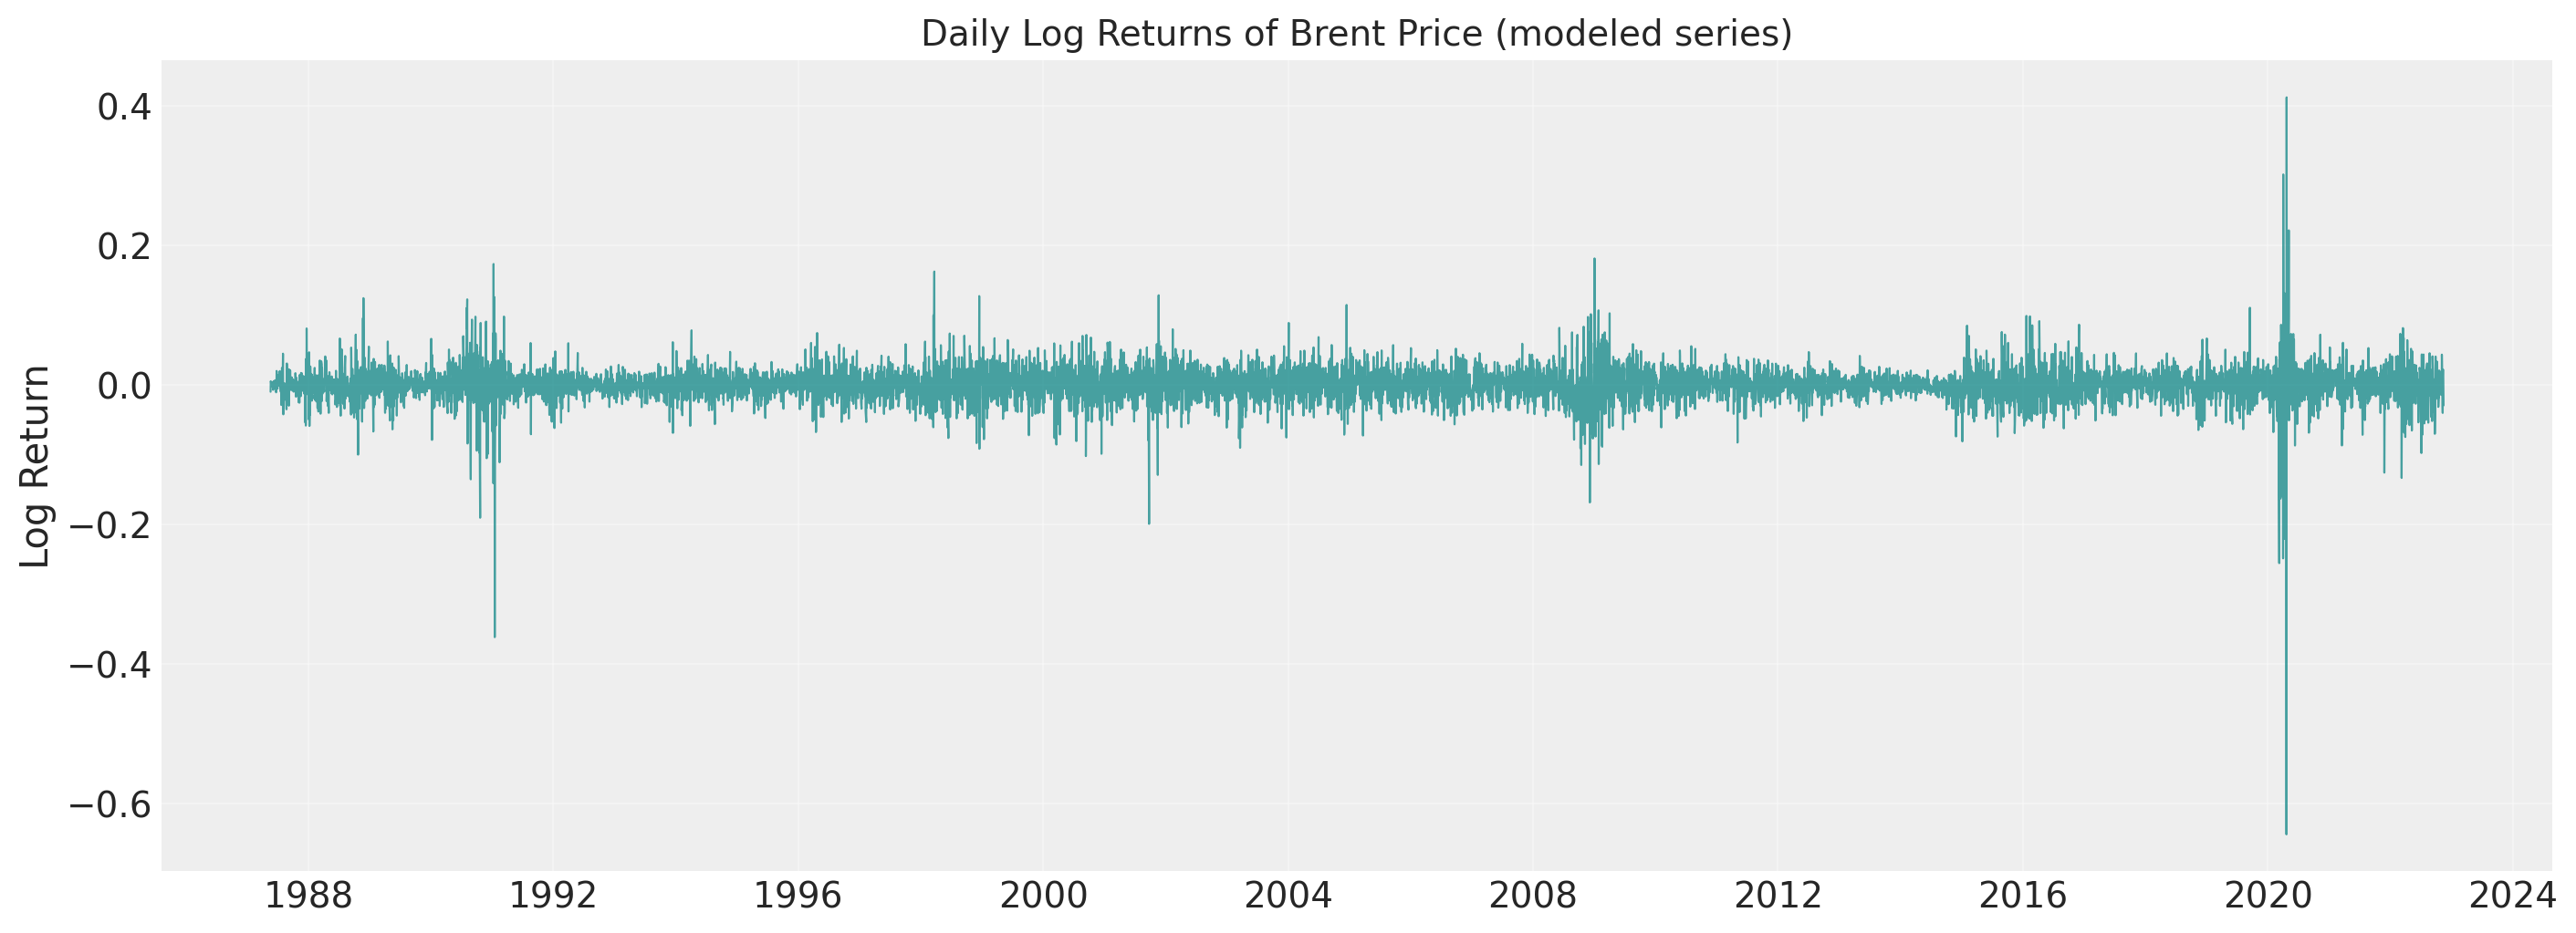

In [4]:
plt.figure(figsize=(14, 5))
plt.plot(df.index[1:], y, lw=0.8, color='teal', alpha=0.7)
plt.title("Daily Log Returns of Brent Price (modeled series)", fontsize=14)
plt.ylabel("Log Return")
plt.grid(alpha=0.3)
plt.show()

## 2. Bayesian Single Change Point Model – PyMC

In [ ]:
with pm.Model() as change_point_model:
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n-1)
    
    mu1 = pm.Normal("mu1", mu=0, sigma=0.05)
    mu2 = pm.Normal("mu2", mu=0, sigma=0.05)
    
    sigma = pm.HalfNormal("sigma", sigma=0.03)
    
    mu_t = pm.math.switch(tau > np.arange(n), mu1, mu2)
    
    obs = pm.Normal("obs", mu=mu_t, sigma=sigma, observed=y)
    
    trace = pm.sample(
        draws=1500,
        tune=1500,
        chains=4,
        target_accept=0.9,
        return_inferencedata=True,
        random_seed=42
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma]


c:\Users\Eyasu\Documents\10th\Change-Point-Analysis-and-Statistical-Modeling-of-Time-Series-Data-week11\.venv\Lib\s
ite-packages\rich\live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

## 3. Convergence Diagnostics & Summary

In [ ]:
print(az.summary(trace, var_names=["tau", "mu1", "mu2", "sigma"]))

In [ ]:
az.plot_trace(trace, var_names=["tau", "mu1", "mu2", "sigma"])
plt.tight_layout()
plt.show()

## 4. Posterior of Change Point τ

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
az.plot_posterior(trace, var_names=["tau"], ax=ax)
ax.set_title("Posterior Distribution of Change Point τ")
ax.set_xlabel("Time index (days since first log return)")
plt.show()

In [ ]:
tau_samples = trace.posterior["tau"].values.flatten()
most_probable_tau = int(np.median(tau_samples))
change_date = df.index[1:][most_probable_tau]

print(f"Most probable change point index: {most_probable_tau}")
print(f"Corresponding date: {change_date.strftime('%Y-%m-%d')}")

## 5. Posterior of Regime Means & Impact

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

az.plot_posterior(trace, var_names=["mu1"], ax=axes[0])
axes[0].set_title("μ before change")

az.plot_posterior(trace, var_names=["mu2"], ax=axes[1])
axes[1].set_title("μ after change")

diff = trace.posterior["mu2"] - trace.posterior["mu1"]
az.plot_posterior(diff, ax=axes[2])
axes[2].set_title("Difference (μ₂ - μ₁)")

plt.tight_layout()
plt.show()

In [ ]:
prob_increase = (diff > 0).mean().values * 100
mean_diff_pct = diff.mean().values * 100

print(f"Probability that mean log return increased after change point: {prob_increase:.1f}%")
print(f"Estimated mean change in daily log return: {mean_diff_pct:.3f}%")

## 6. Associate with Events & Quantify Impact

In [ ]:
major_events_near = {
    "2014-11-27": "OPEC maintains high output → expected ↓ price",
    "2020-04-20": "COVID low / storage crisis",
    "2022-02-24": "Russia invades Ukraine → expected ↑ price"
}

print("\nDetected change around:", change_date.strftime('%Y-%m-%d'))

for date_str, desc in major_events_near.items():
    event_date = pd.to_datetime(date_str)
    days_diff = (change_date - event_date).days
    print(f"  • {desc:<45} ({date_str}) → {days_diff:+4} days difference")

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df.index[1:], y, lw=0.7, color='gray', alpha=0.6, label='Log returns')
plt.axvline(change_date, color='crimson', ls='--', lw=2, label=f'Detected change ({change_date.date()})')
plt.title("Log Returns with Detected Change Point")
plt.legend()
plt.grid(alpha=0.3)
plt.show()